<h2><font color="#004D7F" size=4>UniversityHack2020</font></h2>



<h1><font color="#004D7F" size=5>Reto Minsait Land Classification</font></h1>

<br><br>
<div style="text-align: right">
<font color="#004D7F" size=3>Cristian Cifuentes García, Manuel Bermúdez Martínez</font><br>
<font color="#004D7F" size=3>Curso de Especialista en Ciencia de Datos y Desarrollo de Aplicaciones en la Nube </font><br>
<font color="#004D7F" size=3>Universidad de Castilla-La Mancha</font>

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Índice</font></h2>

* [1. Introducción](#section1)
* [2. Requisitos](#section2)
* [3. Análisis exploratorio de los datos](#section3)
    * [3.1 Tratamiento de las columnas numéricas](#section31)
    * [3.1 Tratamiento de las columnas discretas](#section32)
* [4. Procesamiento del conjunto de datos](#section4)
<br>
---

<a id="section1"></a>
## <font color="#004D7F"> 1. Introducción</font>

<h3><center>Utiliza la información de las imágenes de satélite para clasificar el suelo.</center></h3>

Actualmente, un gran número de satélites toman imágenes con distintos fines y usos. El gran número de imágenes y la gran cantidad de datos que se obtienen de las mismas hace necesario crear modelos predictivos para identificar el contenido de la imagen.

En este reto ya dispondrás de las variables extraídas de la imagen y georeferenciadas, así como variables categóricas asociadas al entorno para estimar un modelo.

<h3><center>El Objetivo</center></h3>

Te retamos a que encuentres el mejor modelo de clasificación automática de suelos en base a las imágenes proporcionadas por el satélite Sentinel II del servicio Copernicus de la Agencia Espacial Europea.

En este reto dispondrás de un conjunto de fincas catastrales asociados a una lista de atributos extraídos de la imagen.

Para ello puedes utilizar las distintas técnicas de Machine Learning disponibles para este tipo de problemas.

La métrica objetivo a maximizar es la “Exactitud”, (en R, en Python) definida como el “Número de registros correctamente clasificados / Número total de registros proporcionados por la Organización”.

<img src="data/mapa_introduccion.jpg">

<h3><center>El Dataset</center></h3>

El dataset contiene un listado de superficies sobre las que se han recortado la imagen de satélite y se han extraído una serie de características de sus geometrías. Finalmente se ha etiquetado el conjunto de los datos según una clasificación de suelo.

---

<a id="section2"></a>
## <font color="#004D7F"> 2. Requisitos</font>

Esta celda está destinada a la importación de los paquetes y librerías necesarias para el desarrollo del problema.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

# Permite que las graficas se generen a mayor resolucion
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

# Establece un ancho de libreta mayor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

from ipywidgets import interact 

# Librerias necesarias para el aprendizaje de modelos


Cargamos el conjunto de datos proporcionado en un fichero de texto plano y lo convertimos en un *dataframe* de *pandas*. Este operación tiene la finalidad de permitirnos trabajar de forma más rápida y eficiente con el conjunto de datos y así, poder realizar un buen análisis exploratorio del mismo.

In [3]:
df_modelar = pd.read_csv('data/Modelar_UH2020.txt', sep="|", index_col='ID', encoding='utf-8')
print("Tamaño del conjunto de datos:  %d" % df_modelar.shape[0])
print("Número de variables: %d" % df_modelar.shape[1])
if df_modelar.index.is_unique:
    print('El índice es único.')
else:
    print('Los índices están duplicados.')

Tamaño del conjunto de datos:  103230
Número de variables: 55
El índice es único.


Podemos observar que contamos con un total de <b>103230 datos</b>, es decir, con una gran cantidad de registros. Este elevado número nos puede ayudar, en gran parte, a desarrollar un modelo con un rendimiento acertado. Por otro lado, contamos con <b>56 variables</b>, pero se ha establecido como índice del conjunto de datos la variable *ID*, tras comprobar que realmente es un identificador único y no se repite, por lo cual, <b>el número de variables disminuye a 55.</b>

In [32]:
list_class_order = ['RESIDENTIAL', 'PUBLIC', 'RETAIL', 'OFFICE', 'INDUSTRIAL', 'AGRICULTURE', 'OTHER']

Esta lista tiene la finalidad de obtener el mismo color en todas las gráficas y representar la variable objetivo siempre en el mismo orden.

---
<a id="section3"></a>
## <font color="#004D7F"> 3. Análisis exploratorio de los datos</font> 

En una primera toma de contacto con los datos, podemos ver una pequeña parte del conjunto para ver qué valores toman cada una de las 55 variables:

In [4]:
df_modelar.head()

,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,...,Q_NIR_8_1_0,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,CLASE
ID,,,,,,,,,,,,,,,,,,,,,
35984B9C3E7CD9A1,2207357872,165920300,0.000000,443.001300,616.001697,746.998401,872.996472,1009.000946,1159.002319,1342.002466,...,10951.926645,144.426900,0.557237,0.067249,0.057372,0.853127,2002,0.0,2,RESIDENTIAL
F9D04BF6D037F8FB,2189757160,165463267,0.000059,443.899011,627.999060,770.001611,904.999988,1032.998474,1165.001636,1316.000110,...,7048.367637,38.342550,0.709884,0.125156,0.147929,1.181953,1949,1.0,8,RESIDENTIAL
B89D5711AFF8C423,2240147335,165690752,0.000000,353.502274,523.003601,644.001831,760.997131,876.999634,1006.997498,1168.995544,...,7013.073271,108.794384,0.517702,0.058268,0.081666,1.401552,1986,1.0,5,RESIDENTIAL
1C3478AC1522E7E4,2227146459,165934099,0.000000,268.000613,376.999609,478.003784,575.001233,683.997742,809.005994,955.002960,...,6216.880538,155.224455,0.450871,0.053591,0.054201,1.011382,1999,1.0,2,RESIDENTIAL
4D12AA5009064345,2212350459,165681791,0.000000,318.997910,492.003845,632.999634,757.002197,882.999908,1019.008911,1175.993103,...,7092.767616,1789.873366,0.458819,0.012858,0.019936,1.550478,1966,8.0,6,RESIDENTIAL


Las variables son las siguientes:

In [5]:
df_modelar.columns.tolist()

['X',
 'Y',
 'Q_R_4_0_0',
 'Q_R_4_0_1',
 'Q_R_4_0_2',
 'Q_R_4_0_3',
 'Q_R_4_0_4',
 'Q_R_4_0_5',
 'Q_R_4_0_6',
 'Q_R_4_0_7',
 'Q_R_4_0_8',
 'Q_R_4_0_9',
 'Q_R_4_1_0',
 'Q_G_3_0_0',
 'Q_G_3_0_1',
 'Q_G_3_0_2',
 'Q_G_3_0_3',
 'Q_G_3_0_4',
 'Q_G_3_0_5',
 'Q_G_3_0_6',
 'Q_G_3_0_7',
 'Q_G_3_0_8',
 'Q_G_3_0_9',
 'Q_G_3_1_0',
 'Q_B_2_0_0',
 'Q_B_2_0_1',
 'Q_B_2_0_2',
 'Q_B_2_0_3',
 'Q_B_2_0_4',
 'Q_B_2_0_5',
 'Q_B_2_0_6',
 'Q_B_2_0_7',
 'Q_B_2_0_8',
 'Q_B_2_0_9',
 'Q_B_2_1_0',
 'Q_NIR_8_0_0',
 'Q_NIR_8_0_1',
 'Q_NIR_8_0_2',
 'Q_NIR_8_0_3',
 'Q_NIR_8_0_4',
 'Q_NIR_8_0_5',
 'Q_NIR_8_0_6',
 'Q_NIR_8_0_7',
 'Q_NIR_8_0_8',
 'Q_NIR_8_0_9',
 'Q_NIR_8_1_0',
 'AREA',
 'GEOM_R1',
 'GEOM_R2',
 'GEOM_R3',
 'GEOM_R4',
 'CONTRUCTIONYEAR',
 'MAXBUILDINGFLOOR',
 'CADASTRALQUALITYID',
 'CLASE']

Y el tipo de datos de cada una de ellas es el siguiente:

In [7]:
df_modelar.dtypes

X                       int64
Y                       int64
Q_R_4_0_0             float64
Q_R_4_0_1             float64
Q_R_4_0_2             float64
Q_R_4_0_3             float64
Q_R_4_0_4             float64
Q_R_4_0_5             float64
Q_R_4_0_6             float64
Q_R_4_0_7             float64
Q_R_4_0_8             float64
Q_R_4_0_9             float64
Q_R_4_1_0             float64
Q_G_3_0_0             float64
Q_G_3_0_1             float64
Q_G_3_0_2             float64
Q_G_3_0_3             float64
Q_G_3_0_4             float64
Q_G_3_0_5             float64
Q_G_3_0_6             float64
Q_G_3_0_7             float64
Q_G_3_0_8             float64
Q_G_3_0_9             float64
Q_G_3_1_0             float64
Q_B_2_0_0             float64
Q_B_2_0_1             float64
Q_B_2_0_2             float64
Q_B_2_0_3             float64
Q_B_2_0_4             float64
Q_B_2_0_5             float64
Q_B_2_0_6             float64
Q_B_2_0_7             float64
Q_B_2_0_8             float64
Q_B_2_0_9 

Se ve a simple vista que predominan las variables numéricas y que el conjunto de datos presenta muy pocas variables discretas. De todas formas, realizaremos un tratamiento específico para cada una de ellas en el apartado correspondiente. 

Hay que tener en cuenta que el principal problema de este reto es el desbalanceo de las clases y por ello mismo, se debe de comprobar cuantos registros tenemos para cada uno de los diferentes valores de la variables a objetivo o a predecir, que es la variable `Clase`.

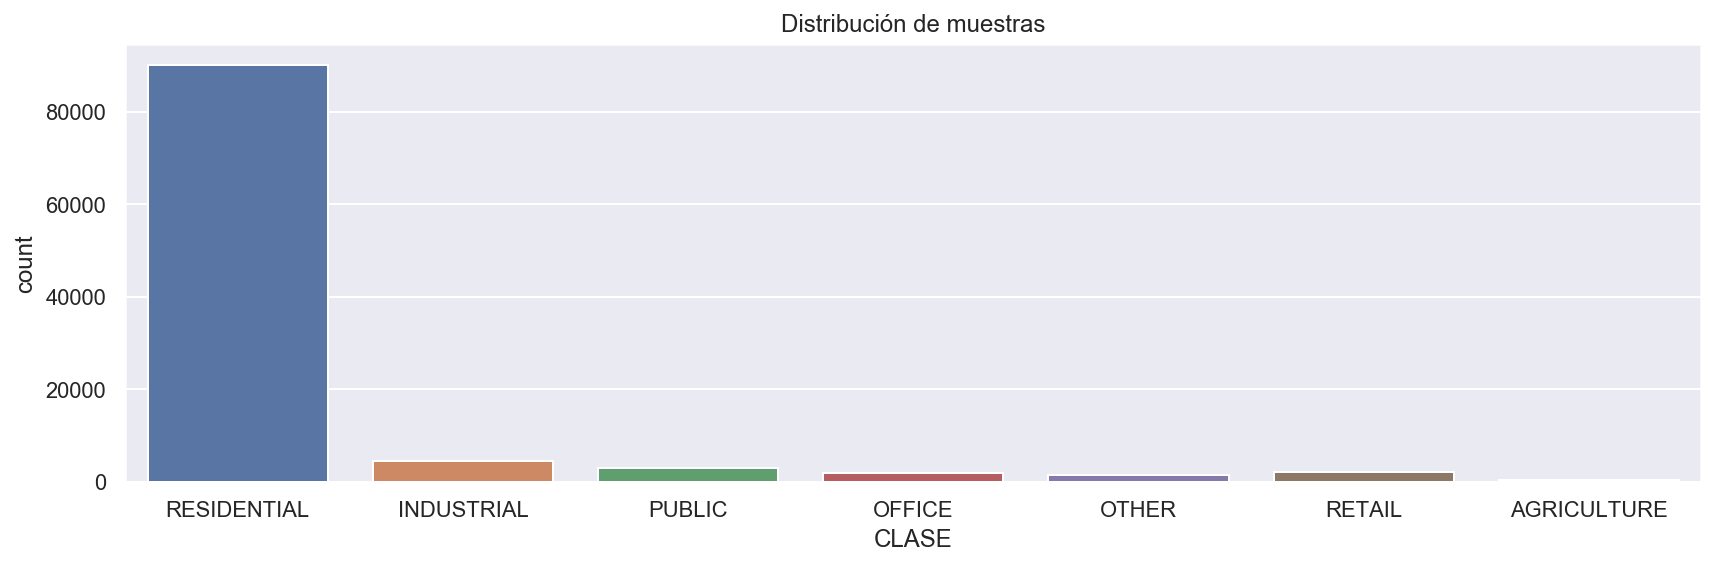

In [9]:
plt.figure(figsize=(12,4))
sns.countplot(x='CLASE', data=df_modelar)
plt.title('Distribución de muestras')
plt.tight_layout()
plt.show()

En la gráfica se puede observar que nos encontramos ante un conjunto de datos muy desbalanceado, ya que el mayor porcentaje de datos corresponde a la clase <b>*Residential*</b> y existe una gran diferencia con el resto de clases del conjunto de datos. De hecho, si nos fijamos a continuación podemos ver el porcentaje que representa cada una de las clases:

In [13]:
for item in df_modelar['CLASE'].unique().tolist():
    total = df_modelar[df_modelar['CLASE']==item]['CLASE'].value_counts().values[0]
    print(f"El porcentaje de muestras de {item} es {(sum(df_modelar['CLASE']==item) / df_modelar.shape[0]):.3f}% con un total de: {total} registros")

El porcentaje de muestras de RESIDENTIAL es 0.874% con un total de: 90173 registros
El porcentaje de muestras de INDUSTRIAL es 0.043% con un total de: 4490 registros
El porcentaje de muestras de PUBLIC es 0.029% con un total de: 2976 registros
El porcentaje de muestras de OFFICE es 0.018% con un total de: 1828 registros
El porcentaje de muestras de OTHER es 0.013% con un total de: 1332 registros
El porcentaje de muestras de RETAIL es 0.020% con un total de: 2093 registros
El porcentaje de muestras de AGRICULTURE es 0.003% con un total de: 338 registros


Partiendo de estos datos, es necesario realizar un profundo análisis de todas columnas de nuestro conjunto de datos, ya que el número total de registros es muy elevado, así como el número de características que presenta el dataset. Para ello, nos centraremos en dividir estas características en función del tipo de dato que representen, como hemos podido observar anteriormente.

En la siguiente celda realizamos esta división, es decir, dividimos las variables en dos listas dependiendo del tipo de dato que representen. Además, en las variables discretas eliminamos la variable `Clase` ya que se trata de la variable objetivo y por el momento no se va a realizar ningún preprocesamiento en ella.

In [16]:
dis_df_columns = df_modelar.select_dtypes(exclude=np.number).columns.tolist()
dis_df_columns.remove('CLASE') #Eliminamos la variable clase
number_df_columns = df_modelar.select_dtypes(include=np.number).columns.tolist()

print('Variables discretas: ',dis_df_columns)
print('\nVariables numéricas: ',number_df_columns)

Variables discretas:  ['CADASTRALQUALITYID']

Variables numéricas:  ['X', 'Y', 'Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3', 'Q_R_4_0_4', 'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7', 'Q_R_4_0_8', 'Q_R_4_0_9', 'Q_R_4_1_0', 'Q_G_3_0_0', 'Q_G_3_0_1', 'Q_G_3_0_2', 'Q_G_3_0_3', 'Q_G_3_0_4', 'Q_G_3_0_5', 'Q_G_3_0_6', 'Q_G_3_0_7', 'Q_G_3_0_8', 'Q_G_3_0_9', 'Q_G_3_1_0', 'Q_B_2_0_0', 'Q_B_2_0_1', 'Q_B_2_0_2', 'Q_B_2_0_3', 'Q_B_2_0_4', 'Q_B_2_0_5', 'Q_B_2_0_6', 'Q_B_2_0_7', 'Q_B_2_0_8', 'Q_B_2_0_9', 'Q_B_2_1_0', 'Q_NIR_8_0_0', 'Q_NIR_8_0_1', 'Q_NIR_8_0_2', 'Q_NIR_8_0_3', 'Q_NIR_8_0_4', 'Q_NIR_8_0_5', 'Q_NIR_8_0_6', 'Q_NIR_8_0_7', 'Q_NIR_8_0_8', 'Q_NIR_8_0_9', 'Q_NIR_8_1_0', 'AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4', 'CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR']


Una vez tenemos hecha la división de forma correcta, debemos de realizar un el tratamiento de forma independiente y así, comprobar si realmente pertenecen al tipo de datos que representa la variable o se pueden convertir.

<a id="section31"></a>
### <font color="#004D7F">3.1 Tratamiento de las columnas numéricas </font>

El tratamiento de las columnas numéricas es relativamente sencillo, y se puede descomponer en varias etapas:

* Comprobar que, efectivamente, corresponden a características numéricas. 
* Detección y tratamiento de outliers. 
* Detección y tratemiento de valores perdidos. 
* Exploración de las variables. 

Lo primero que se comprueba es su realmente estas variables son numéricas o se pueden convertir a discretas, por ejemplo, si una variable tiene unicamente tres valores se convertirá en una variable discreta en vez de numérica.

In [18]:
num_df_values = [(col, len(df_modelar[col].value_counts())) for col in number_df_columns]
num_df_values

[('X', 103132),
 ('Y', 93969),
 ('Q_R_4_0_0', 141),
 ('Q_R_4_0_1', 230),
 ('Q_R_4_0_2', 230),
 ('Q_R_4_0_3', 230),
 ('Q_R_4_0_4', 230),
 ('Q_R_4_0_5', 230),
 ('Q_R_4_0_6', 229),
 ('Q_R_4_0_7', 230),
 ('Q_R_4_0_8', 230),
 ('Q_R_4_0_9', 230),
 ('Q_R_4_1_0', 229),
 ('Q_G_3_0_0', 172),
 ('Q_G_3_0_1', 230),
 ('Q_G_3_0_2', 229),
 ('Q_G_3_0_3', 230),
 ('Q_G_3_0_4', 229),
 ('Q_G_3_0_5', 230),
 ('Q_G_3_0_6', 230),
 ('Q_G_3_0_7', 230),
 ('Q_G_3_0_8', 230),
 ('Q_G_3_0_9', 230),
 ('Q_G_3_1_0', 228),
 ('Q_B_2_0_0', 211),
 ('Q_B_2_0_1', 229),
 ('Q_B_2_0_2', 226),
 ('Q_B_2_0_3', 227),
 ('Q_B_2_0_4', 227),
 ('Q_B_2_0_5', 227),
 ('Q_B_2_0_6', 227),
 ('Q_B_2_0_7', 228),
 ('Q_B_2_0_8', 230),
 ('Q_B_2_0_9', 229),
 ('Q_B_2_1_0', 228),
 ('Q_NIR_8_0_0', 207),
 ('Q_NIR_8_0_1', 230),
 ('Q_NIR_8_0_2', 230),
 ('Q_NIR_8_0_3', 230),
 ('Q_NIR_8_0_4', 230),
 ('Q_NIR_8_0_5', 230),
 ('Q_NIR_8_0_6', 229),
 ('Q_NIR_8_0_7', 230),
 ('Q_NIR_8_0_8', 230),
 ('Q_NIR_8_0_9', 230),
 ('Q_NIR_8_1_0', 228),
 ('AREA', 103226),
 ('G

Por lo que parece, todas las variables ellas son numéricas y no se debe de realizar ningun cambio para ellas. Al tener un alto número de variables vamos a realizar subdivisiones en función de la identificación de cada una de ellas.

- **Colores:** 'Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3', 'Q_R_4_0_4', 'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7', 'Q_R_4_0_8', 'Q_R_4_0_9', 'Q_R_4_1_0', 'Q_G_3_0_0', 'Q_G_3_0_1', 'Q_G_3_0_2', 'Q_G_3_0_3', 'Q_G_3_0_4', 'Q_G_3_0_5', 'Q_G_3_0_6', 'Q_G_3_0_7', 'Q_G_3_0_8', 'Q_G_3_0_9', 'Q_G_3_1_0', 'Q_B_2_0_0', 'Q_B_2_0_1', 'Q_B_2_0_2', 'Q_B_2_0_3', 'Q_B_2_0_4', 'Q_B_2_0_5', 'Q_B_2_0_6', 'Q_B_2_0_7', 'Q_B_2_0_8', 'Q_B_2_0_9', 'Q_B_2_1_0', 'Q_NIR_8_0_0', 'Q_NIR_8_0_1', 'Q_NIR_8_0_2', 'Q_NIR_8_0_3', 'Q_NIR_8_0_4', 'Q_NIR_8_0_5', 'Q_NIR_8_0_6', 'Q_NIR_8_0_7', 'Q_NIR_8_0_8', 'Q_NIR_8_0_9', 'Q_NIR_8_1_0'
- **Geométricas:** 'AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4'
- **Otras:** 'CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR'

In [19]:
position = ['X', 'Y']
colors = ['Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3', 'Q_R_4_0_4', 'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7',
          'Q_R_4_0_8', 'Q_R_4_0_9', 'Q_R_4_1_0', 'Q_G_3_0_0', 'Q_G_3_0_1', 'Q_G_3_0_2', 'Q_G_3_0_3', 'Q_G_3_0_4',
          'Q_G_3_0_5', 'Q_G_3_0_6', 'Q_G_3_0_7', 'Q_G_3_0_8', 'Q_G_3_0_9', 'Q_G_3_1_0', 'Q_B_2_0_0', 'Q_B_2_0_1',
          'Q_B_2_0_2', 'Q_B_2_0_3', 'Q_B_2_0_4', 'Q_B_2_0_5', 'Q_B_2_0_6', 'Q_B_2_0_7', 'Q_B_2_0_8', 'Q_B_2_0_9',
          'Q_B_2_1_0', 'Q_NIR_8_0_0', 'Q_NIR_8_0_1', 'Q_NIR_8_0_2', 'Q_NIR_8_0_3', 'Q_NIR_8_0_4', 'Q_NIR_8_0_5', 
          'Q_NIR_8_0_6', 'Q_NIR_8_0_7', 'Q_NIR_8_0_8', 'Q_NIR_8_0_9', 'Q_NIR_8_1_0']
geom = ['AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4']
others = ['CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR']

#### <font color="#004D7F"> Variables realtivas a las posiciones </font>

La información de longitud-latitud ha sido escalada y desplazada aleatoriamente (manteniendo la relación de posición con el resto de puntos). Aún así vamos a intentar dibujar los puntos que tenemos en el conjunto de datos con respecto a la latitud y la longitud para hacernos una idea de las parcelas y de la clase que presentan.

Primeramente comprobamos si presenta o no valores perdidos. En este caso no presenta valores perdidos y por lo tanto no es realizar ningun tipo de análisis extra.

In [44]:
df_modelar[position].isna().sum()[df_modelar[position].isna().sum()>0]

Series([], dtype: int64)

In [ ]:
plt.figure(figsize=(30,20))
sns.scatterplot(x="X", y="Y", hue="CLASE",data=df_modelar)
plt.axis('off');

A continuación vamos a analizar cada una de las distribuiciones de las clases en función a sus posiciones geográficas, para ver que información nos pueden trasmitir.

In [ ]:
sns.relplot(x="X", y="Y", col="CLASE", hue="CLASE", kind="scatter", col_wrap=3, data=df_modelar);

Se puede observar en ambas gráficas que, aunque estos datos estén falseados, nos podemos hacer una pequeña idea de la situación de cada uno de los registros en función de la clase con la cual han sido clasificados. Por ejemplo, podemos observar que los registros pertenecientes a la clase de `Agricultura` se encuentran a las *afueras*, mientras que el resto de registros están mas céntricos.

Por otro lado se pueden ver pequeñas zonas o agrupaciones de registros, que probablemente con algun tipo de modelo de clasificación mediante *clusters* se clasificarían correctamente.

#### <font color="#004D7F"> Variables realtivas a los colores </font>

Primeramente comprobamos si presenta o no valores perdidos. En este caso no presenta valores perdidos y por lo tanto no es realizar ningun tipo de análisis extra.

In [43]:
df_modelar[colors].isna().sum()[df_modelar[colors].isna().sum()>0]

Series([], dtype: int64)

In [20]:
df_modelar[colors].describe()

,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,Q_R_4_0_8,Q_R_4_0_9,...,Q_NIR_8_0_1,Q_NIR_8_0_2,Q_NIR_8_0_3,Q_NIR_8_0_4,Q_NIR_8_0_5,Q_NIR_8_0_6,Q_NIR_8_0_7,Q_NIR_8_0_8,Q_NIR_8_0_9,Q_NIR_8_1_0
count,1.032300e+05,103230.000000,103230.000000,103230.000000,103230.000000,103230.000000,103230.000000,103230.000000,103230.000000,103230.000000,...,103230.000000,103230.000000,103230.000000,103230.000000,103230.000000,103230.000000,103230.000000,103230.000000,103230.000000,103230.000000
mean,4.578804e-05,382.633602,548.659095,684.016575,811.053925,939.978002,1080.127592,1242.841586,1455.156651,1790.156782,...,814.276061,1102.612169,1315.749309,1499.915698,1676.426383,1860.014128,2066.630198,2328.363095,2738.622278,7748.293927
std,3.168761e-03,99.470870,121.439858,137.763573,153.486424,169.546408,186.422410,206.993926,234.809582,269.389796,...,228.324271,234.721672,234.891233,235.476530,239.760730,248.165718,264.334062,295.852549,365.812714,2795.775635
min,0.000000e+00,151.000375,184.999420,214.000473,239.999503,269.999451,310.999493,382.999844,459.001373,591.000671,...,328.703671,700.003967,914.001007,1099.995972,1264.005249,1435.997559,1632.993774,1861.006226,2172.992676,4085.049076
25%,0.000000e+00,316.997635,492.003845,632.999634,753.999597,875.008087,1006.997498,1173.999329,1378.988965,1691.304590,...,649.703033,952.999451,1151.004639,1336.003833,1513.998901,1692.994263,1878.997437,2126.002441,2478.998193,6051.309064
50%,0.000000e+00,385.000995,562.997583,698.003998,833.996582,969.999817,1115.001489,1268.997705,1479.002441,1783.003601,...,782.505676,1088.002075,1328.011536,1525.002368,1700.000305,1873.000610,2067.002441,2313.999268,2688.000000,6798.207198
75%,5.786675e-07,445.002853,627.001038,770.001611,904.999988,1042.505188,1200.006226,1348.996033,1550.000244,1884.999426,...,935.499146,1222.998193,1436.998584,1628.998413,1808.002502,1978.989258,2194.001978,2491.004199,2940.996704,8033.479864
max,1.016050e+00,833.999402,1016.000732,1200.003003,1377.999927,1570.504517,1806.002686,2175.694824,2575.792188,2940.000635,...,2055.998657,2324.008301,2579.501465,2801.996582,2983.994995,3158.000488,3408.002808,3750.997559,4614.998535,15848.608811


Como estudiar la correlación de todas y cada una de las variables relacionadas con el color es inviable y no se observarían correctamente los datos, lo que haremos es un agrupamiento por colores, es decir, tendremos lo siguiente:

- **Rojo**
- **Verde**
- **Azul**
- **NIR**

In [ ]:
# Correlación perteneciente al color rojo
df_modelar[colors[:11]].corr().style.background_gradient()

Para el color rojo podemos observar que existe una gran correlación entre casi todas las variables, excepto con las pertenecientes al decil 0 y 10. Por otro lado se puede observar que cada una de ellas presenta una mayor correlación con su respectivo antecesor y sucesor. Por ejemplo, la variable *Q_R_4_0_5* presenta una mayor correlación con *Q_R_4_0_4* y *Q_R_4_0_6*

Como excepción, decir que el decil 9 (*Q_R_4_0_9*) presenta una mayor correlación con sus dos antecesores.

In [ ]:
# Correlación perteneciente al color verde
df_modelar[colors[11:22]].corr().style.background_gradient()

En el caso del color verde ocurre exactamente lo mismo que para el color rojo, ya que la máxima correlación la presentan con su decil anterior y posterior.

In [ ]:
# Correlación perteneciente al color azul
df_modelar[colors[22:33]].corr().style.background_gradient()

Ocurre lo mismo con el color azul y también para el NIR.

In [ ]:
# Correlación perteneciente al color azul
df_modelar[colors[33:44]].corr().style.background_gradient()

#### <font color="#004D7F"> Variables realtivas a la geometría </font>

Primeramente comprobamos si presenta o no valores perdidos. En este caso no presenta valores perdidos y por lo tanto no es realizar ningun tipo de análisis extra.

In [45]:
df_modelar[geom].isna().sum()[df_modelar[geom].isna().sum()>0]

Series([], dtype: int64)

In [22]:
df_modelar[geom].describe()

,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4
count,103230.000000,103230.000000,103230.000000,103230.000000,103230.000000
mean,441.123610,0.563343,0.062482,0.061855,1.074327
std,1869.705189,0.174141,0.042849,0.042295,0.541156
min,0.038770,0.000626,0.000679,0.000770,0.015157
25%,97.477454,0.455183,0.038255,0.038153,0.801352
50%,171.554907,0.536336,0.055802,0.055036,0.997175
75%,343.563671,0.674723,0.078477,0.078064,1.223456
max,238058.952253,1.000000,1.785714,2.631579,68.812431


En este caso podemos observar que existe una gran diferencia y que los valores máximos y mínimos se alejan enormemente de los rangos, como también se observa en el siguiente diagrama de cajas. Por ello mismo, se ha decidido eliminar lo que actualmente se consideran outliers.

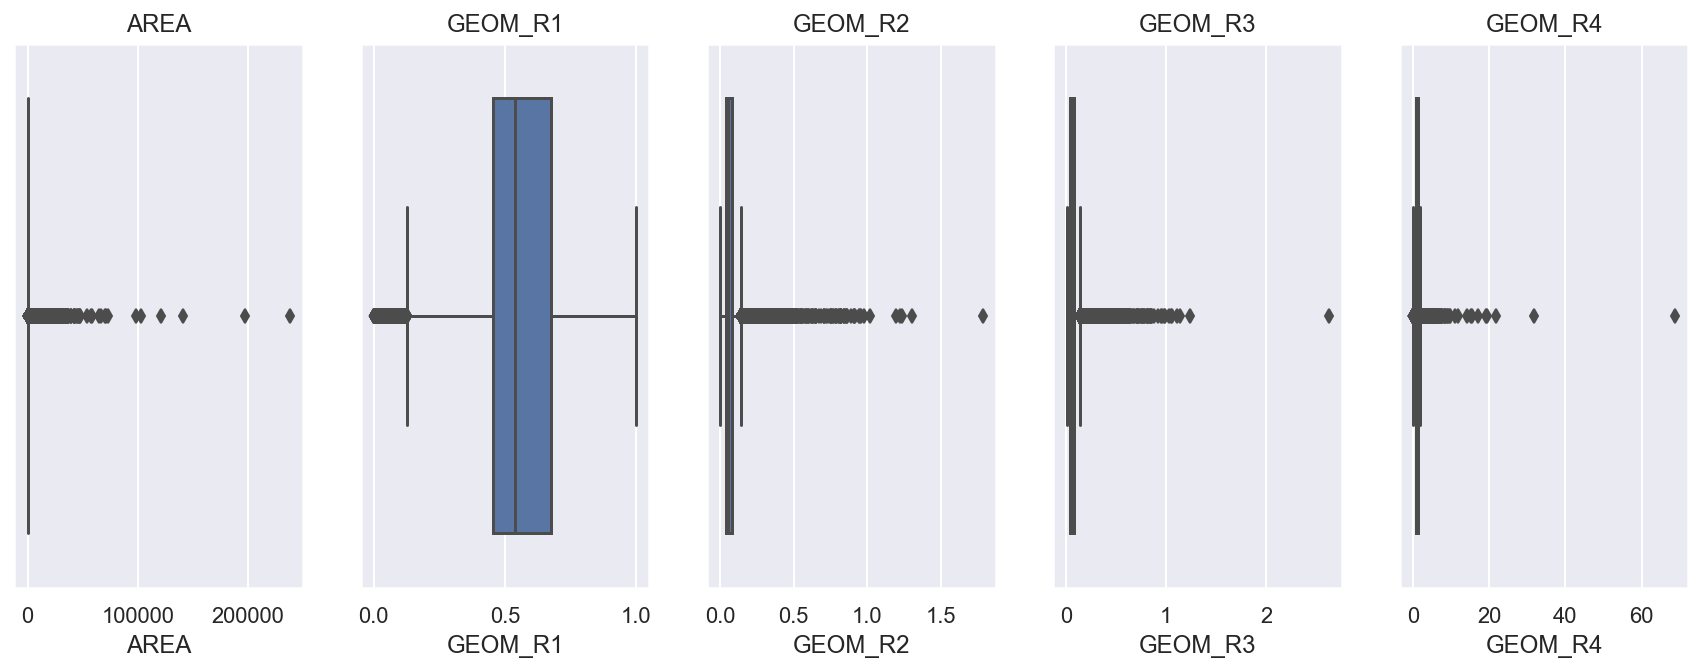

In [24]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for col, ax in enumerate(axs.flatten()):
    col_name = geom[col]
    sns.boxplot(x=df_modelar[col_name], ax=ax)
    ax.set_title(col_name);    
    ax.set_yticks([])

Con la eliminación de outliers obtenemos el siguiente diagrama de cajas.

In [26]:
def delete_outliers_geom(df, columns):
    df_aux = df.copy()
    for col_name in columns:
        if col_name == 'AREA':
            third_quantile_area = df_aux[col_name].quantile(0.8)
            df_aux = df_aux[df_aux[col_name] < third_quantile_area]
        elif col_name == 'GEOM_R1':
            first_quantile_area = df_aux[col_name].quantile(0.016)
            third_quantile_area = df_aux[col_name].quantile(0.92)
            df_aux = df_aux[(df_aux[col_name] > first_quantile_area) & (df_aux[col_name] < third_quantile_area)]
        elif col_name == 'GEOM_R2':
            third_quantile_area = df_aux[col_name].quantile(0.96)
            df_aux = df_aux[df_aux[col_name] < third_quantile_area]
        elif col_name == 'GEOM_R3':
            third_quantile_area = df_aux[col_name].quantile(0.96)
            df_aux = df_aux[df_aux[col_name] < third_quantile_area]
        elif col_name == 'GEOM_R4':
            third_quantile_area = df_aux[col_name].quantile(0.93)
            first_quantile_area = df_aux[col_name].quantile(0.005)
            df_aux = df_aux[(df_aux[col_name] > first_quantile_area) & (df_aux[col_name] < third_quantile_area)]
        
    return df_aux
df_aux = delete_outliers_geom(df_modelar, geom)

Después de aplicar una eliminación de los supuestos outliers obtenemos el siguiente diagrama de cajas:

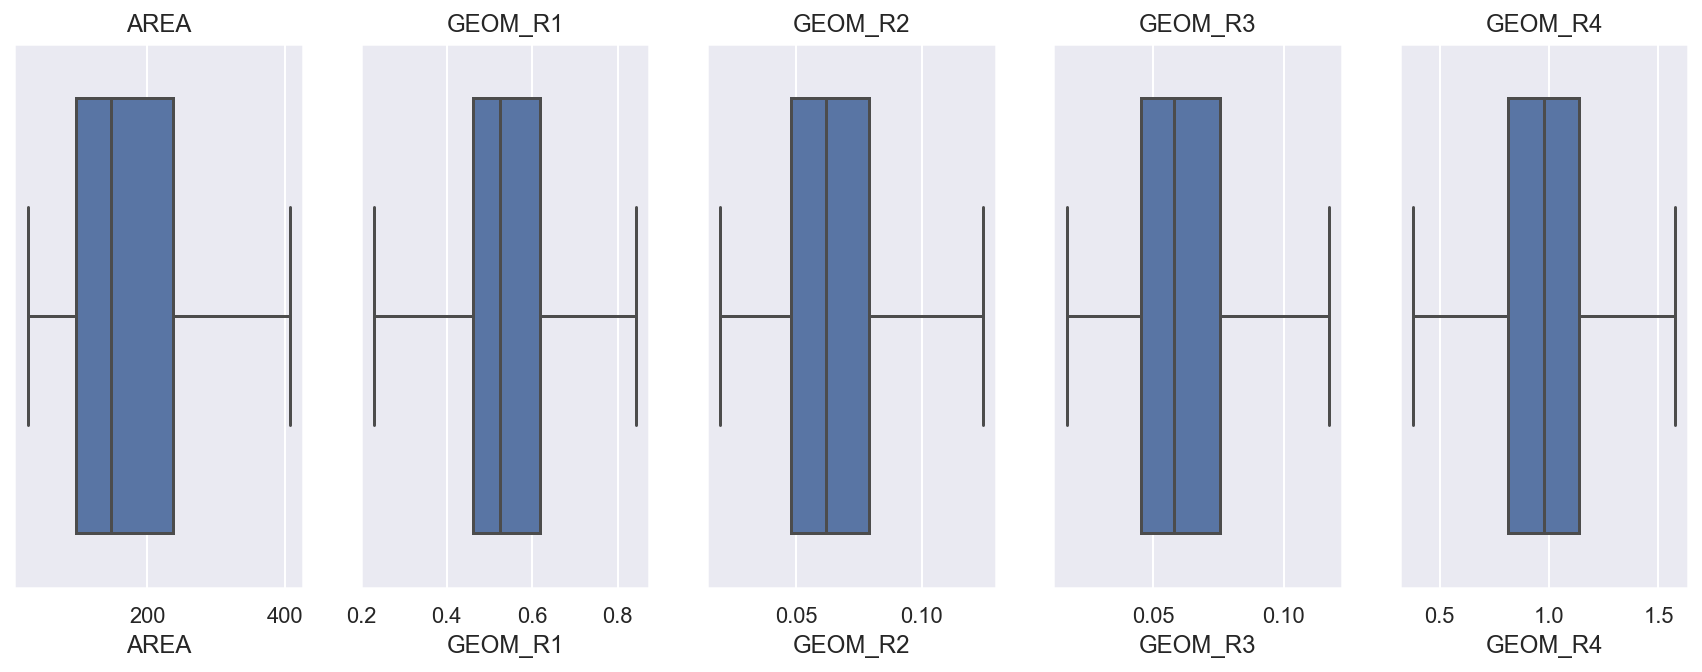

In [38]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for col, ax in enumerate(axs.flatten()):
    col_name = geom[col]
    sns.boxplot(x=df_aux[col_name], ax=ax)
    ax.set_title(col_name);    
    ax.set_yticks([])

In [29]:
print(f"Dataset con outliers: {df_modelar.shape}")
print(f"Dataset sin outliers: {df_aux.shape}")

Dataset con outliers: (103230, 55)
Dataset sin outliers: (63639, 55)


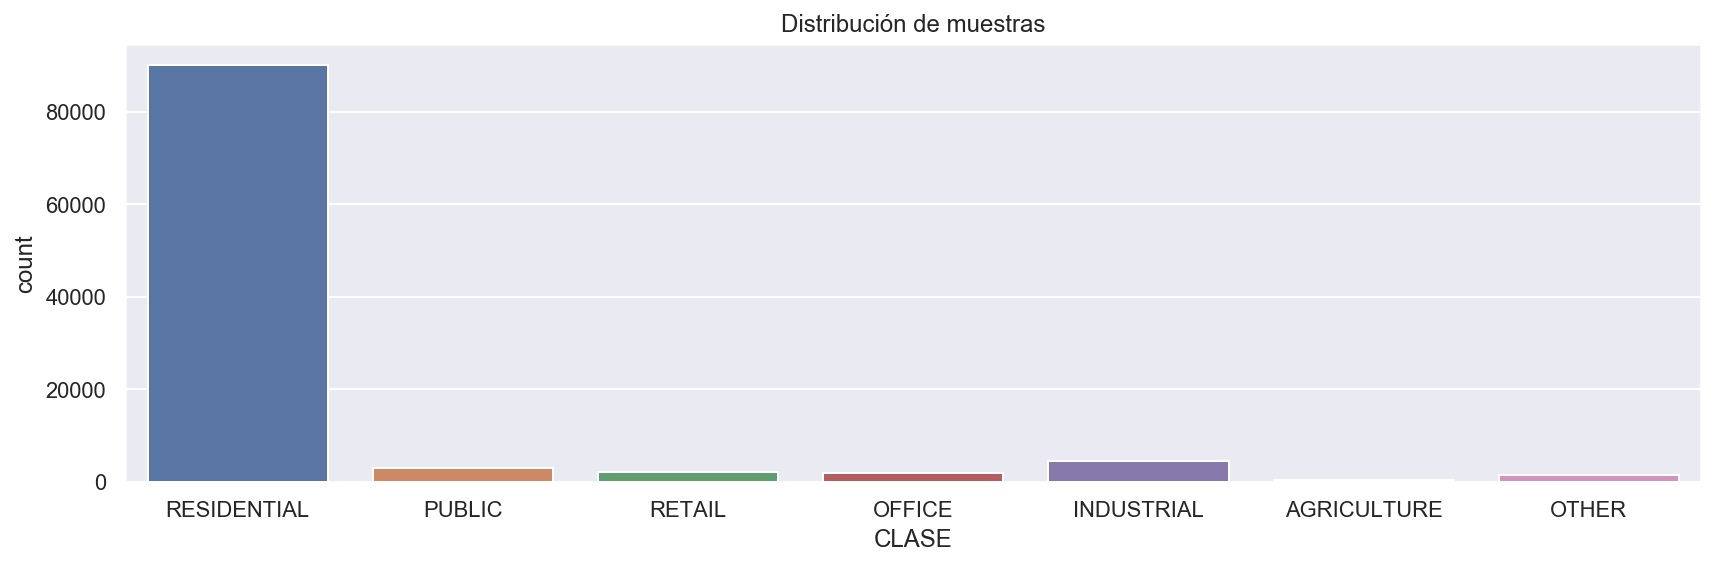

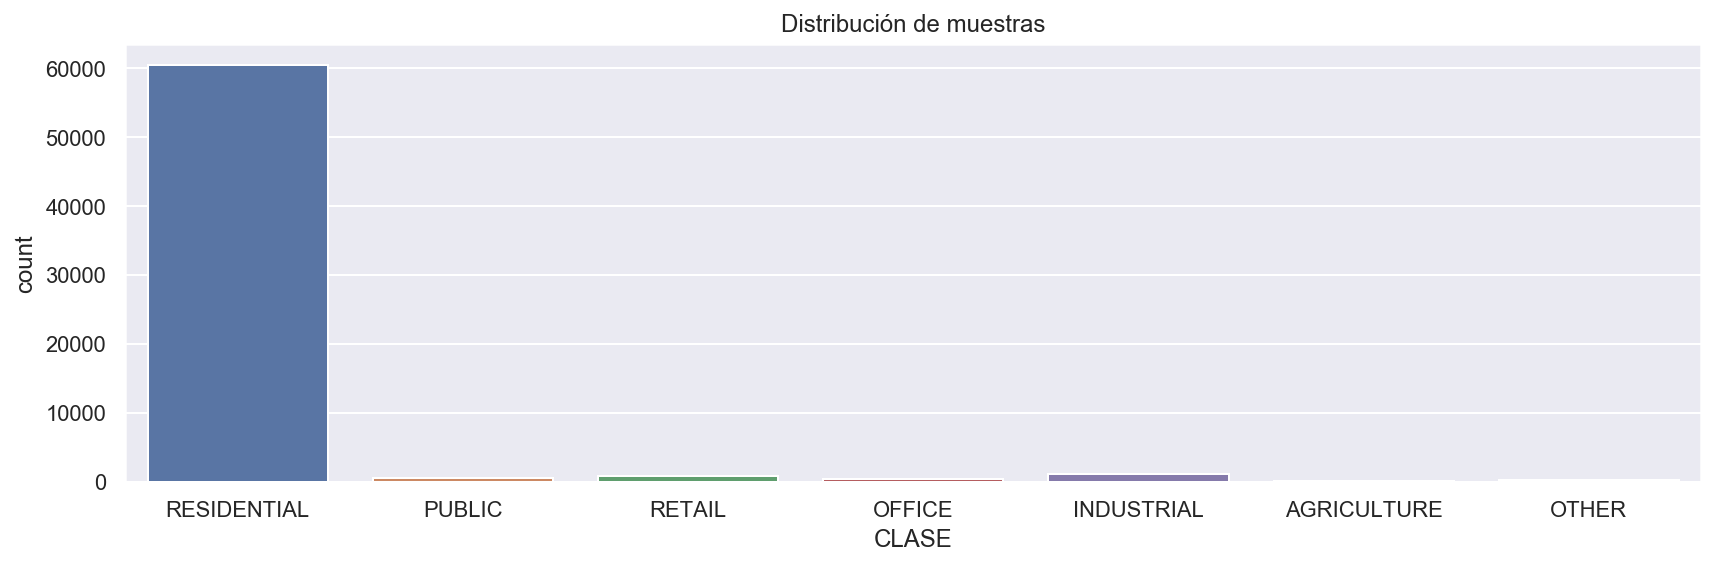

In [37]:
plt.figure(figsize=(12,4))
sns.countplot(x='CLASE', data=df_modelar, order=list_class_order)
plt.title('Distribución de muestras')
plt.tight_layout()
plt.show()
plt.figure(figsize=(12,4))
sns.countplot(x='CLASE', data=df_aux, order=list_class_order);
plt.title('Distribución de muestras')
plt.tight_layout()
plt.show()

La eliminación de outliers reduce considerablemente el número de registros de nuestro conjunto de datos y es por ello por lo que debemos de valorar si se deben de eliminar o no estos outliers o si realmente se trata de outliers o no. 

Aún así, si comprobamos la correlación de este conjunto de variables, con y sin outliers podemos observar que el hecho de eliminar tantos registros nos mejora apenas la correlación.

In [41]:
with_outliers = df_modelar.corr()[geom]
with_outliers.style.background_gradient()

,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4
X,0.0282305,-0.0531069,-0.0159406,-0.00274283,0.00261913
Y,-0.00448588,-0.0473514,-0.0151681,-0.0283479,-0.00916509
Q_R_4_0_0,0.00145163,-0.00792506,-0.0010346,-4.81311e-05,0.000853398
Q_R_4_0_1,0.0304078,0.0167191,0.0219693,0.0298332,0.0132957
Q_R_4_0_2,0.0308048,0.0152384,0.00258997,0.012477,0.0133241
Q_R_4_0_3,0.0320902,0.0151304,-0.0143925,-0.00174369,0.0147091
Q_R_4_0_4,0.034419,0.0158803,-0.0265888,-0.0120245,0.0165426
Q_R_4_0_5,0.0380233,0.0175466,-0.0336133,-0.01743,0.0184691
Q_R_4_0_6,0.0431031,0.0225364,-0.0380659,-0.020345,0.0214621
Q_R_4_0_7,0.0492271,0.0280156,-0.041979,-0.0232368,0.0244707


In [42]:
without_outliers = df_aux.corr()[geom]
without_outliers.style.background_gradient()

,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4
X,-0.0400471,-0.0395231,0.0285211,0.065523,0.0395056
Y,0.0204468,-0.00685914,-0.0422313,-0.0640336,-0.0153853
Q_R_4_0_0,-0.10755,0.0160893,0.108719,0.144811,0.0303684
Q_R_4_0_1,-0.0849093,-0.0194831,0.0714574,0.0997141,0.0272874
Q_R_4_0_2,-0.0451616,-0.0152471,0.0352764,0.0660032,0.0309899
Q_R_4_0_3,-0.0211711,-0.00691413,0.0152766,0.046732,0.0320153
Q_R_4_0_4,-0.00652961,0.000774185,0.00419691,0.0353535,0.0317119
Q_R_4_0_5,0.000801665,0.0066973,0.000138732,0.0306339,0.0311981
Q_R_4_0_6,0.00589622,0.0135809,-0.00198975,0.0276722,0.0308551
Q_R_4_0_7,0.00984275,0.0200159,-0.00374211,0.0235357,0.0292524


#### <font color="#004D7F"> Otras variables </font>

Primeramente comprobamos si presenta o no valores perdidos. En este caso si presenta valores perdidos y por lo tanto es conveniente realizar un análisis extra.

In [46]:
df_modelar[others].isna().sum()[df_modelar[others].isna().sum()>0]

MAXBUILDINGFLOOR    20
dtype: int64

Si ahora realizamos una comprobación del conjunto de datos completo podemos observar que hay otra variable discreta que también presenta valores perdidos:

In [47]:
df_modelar.isna().sum()[df_modelar.isna().sum()>0]

MAXBUILDINGFLOOR      20
CADASTRALQUALITYID    20
dtype: int64

In [51]:
df_modelar[df_modelar.isna().any(axis=1)]

,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,...,Q_NIR_8_1_0,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,CLASE
ID,,,,,,,,,,,,,,,,,,,,,
B7DE3FE20084F9FA,2254413625,165244276,0.000597,592.998193,742.001184,855.996881,976.798755,1106.998474,1238.995532,1386.001807,...,6763.517046,2120.276750,0.465508,0.015959,0.013757,0.862017,1975,NaN,NaN,INDUSTRIAL
5D08956CDC0B7C37,2250193143,165232359,0.000000,648.000018,788.999866,894.999255,987.001318,1079.999817,1184.999121,1317.997363,...,6084.405066,1999.778850,0.531552,0.016810,0.015813,0.940702,1975,NaN,NaN,AGRICULTURE
20D3200047F4D73A,2254610358,165241603,0.000597,592.998193,742.001184,855.996881,976.798755,1106.998474,1238.995532,1386.001807,...,6763.517046,723.268350,0.563042,0.036284,0.021455,0.591289,1975,NaN,NaN,AGRICULTURE
82489ECC7BDFB0B0,2250087048,165252257,0.000000,648.000018,788.999866,894.999255,987.001318,1079.999817,1184.999121,1317.997363,...,6084.405066,1829.160728,0.153173,0.009619,0.008705,0.905010,1975,NaN,NaN,RETAIL
6447D96932B64C3F,2250800402,165234583,0.000000,648.000018,788.999866,894.999255,987.001318,1079.999817,1184.999121,1317.997363,...,6084.405066,249.497550,0.361907,0.040209,0.036075,0.897186,1975,NaN,NaN,AGRICULTURE
8BF6E2CB5B152739,2248534716,165225185,0.000000,648.000018,788.999866,894.999255,987.001318,1079.999817,1184.999121,1317.997363,...,6084.405066,159.968400,0.294582,0.042373,0.043459,1.025641,1975,NaN,NaN,AGRICULTURE
621448B2B12E3B3E,2233865202,165097257,0.000009,609.998492,778.999695,889.001544,976.000098,1068.000366,1169.998853,1271.998901,...,5208.317414,710.658165,0.115690,0.014473,0.011248,0.777191,1950,NaN,NaN,AGRICULTURE
042ABAFAE9B5BDB9,2246045656,165214428,0.000000,648.000018,788.999866,894.999255,987.001318,1079.999817,1184.999121,1317.997363,...,6084.405066,4112.808185,0.028464,0.003521,0.001966,0.558325,1966,NaN,NaN,INDUSTRIAL
55B7201B5219C83B,2260254994,165132637,0.000004,437.000958,597.003247,711.998651,806.999329,910.999084,1039.000195,1183.999719,...,5922.090811,47.266733,0.043968,0.031348,0.029674,0.946588,1982,NaN,NaN,AGRICULTURE


Vemos que en realidad estos 40 valores perdidos corresponden unicamente con 20 registros de nuestro conjunto de datos, ya que casualmente los valores perdidos se presentan de forma simultánea tanto en la variable `CONTRUCTIONYEAR` como `MAXBUILDINGFLOOR`. Dado los valores perdidos pertenecen a las clases más desbalanceadas de nuestro conjunto se debe de tomar la decisión de qué hacer con los valores perdidos. 

También se debe de tener en cuenta que la variable `CONTRUCTIONYEAR` tiene un orden que indica la calidad del terreno, por lo que no podríamos establecer cualquier valor. Esta decisión se resolverá más adelante.

<a id="section32"></a>
### <font color="#004D7F">3.2 Tratamiento de las columnas discretas </font>


En relación a estas columnas, dos aspectos muy relevantes de cara a la construcción de un modelo con `scikit-learn` son: el número de valores que puede tomar cada una; y si existe una relación de orden entre estos valores. Estos factores determinan el tipo de transformación que se ha de hacer. Existen cuatro posibilidades:

* Cuando la columna toma dos valores, se puede binarizar y convertir a numérica diréctamente. 
* Si el tamaño del conjunto de valores es mayor que dos, y no existe una relación de orden entre ellos, se aplica `One Hot Encoding` (se aplicará posteriormente en el `Pipeline` de transformaciones).
* Si existe una relación de orden, los valores se transforman a numéricos, sustituyendo cada valor por su orden. 
* Si el conjunto de valores extremadamente grande se ha de explorar, ya que es muy posible que se trate de un error.

In [53]:
# Recordar que la variable CLASE también es discreta pero se ha eliminado al ser la varible objetivo
num_values_dis_df_col = [(col, len(df_modelar[col].value_counts())) for col in dis_df_columns]
num_values_dis_df_col

[('CADASTRALQUALITYID', 12)]

De esta variable en concreto tenemos una información adicional y es que se trata de una variable categórica representativa de la calidad y que tiene un órden:

<b>MAYOR a MENOR CALIDAD: A > B > C > 1 > 2 > 3 >...> 8 > 9</b>

Por lo tanto, lo primero que debemos de hacer es establecer ese órden en estas variable en el conjunto de datos.

In [61]:
# TODO: ¿Tratamos aqui ya los valores perdidos o sigo poniendo nan?
def process_cadastralquality(value):
    dic = {'A': 11, 'B': 10, 'C': 9}
    if value in dic:
        return dic[value]
    else:
        try:
            return 9 - int(value)
        except ValueError:
            return np.nan

In [58]:
df_modelar['CADASTRALQUALITYID'] = df_modelar['CADASTRALQUALITYID'].apply(process_cadastralquality)

In [59]:
df_modelar['CADASTRALQUALITYID'].value_counts()

5.0     24621
3.0     24528
4.0     19473
2.0     13799
6.0     10209
1.0      5547
7.0      2980
0.0      1105
8.0       652
9.0       216
10.0       43
11.0       37
Name: CADASTRALQUALITYID, dtype: int64

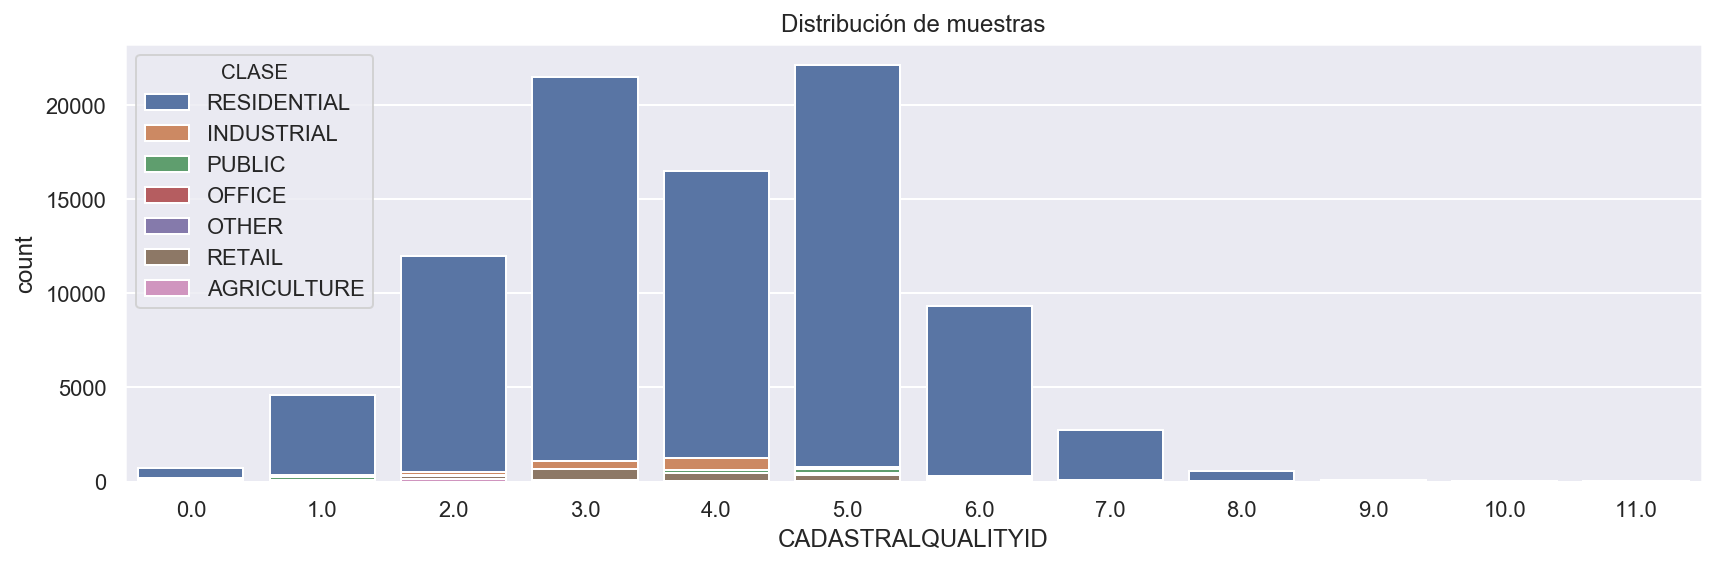

In [64]:
plt.figure(figsize=(12,4))
sns.countplot(x=df_modelar['CADASTRALQUALITYID'], data=df_modelar, hue="CLASE", dodge=False)
plt.title('Distribución de muestras');
plt.tight_layout()